<a href="https://colab.research.google.com/github/DM872/Material/blob/main/TSP/tsp_gurobi.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# DM872 A Cutting Plane Approach for the Traveling Salesman Problem

## Traveling Salesman Problem

Part of this notebook is taken from the very nice tutorial by Peter Norvig:
http://nbviewer.jupyter.org/url/norvig.com/ipython/TSP.ipynb

Consider the [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):

> Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?

## Representing an instance of the problem

The only thing that matters about cities is the distance between them. We will ignore the fully general TSP where distances can be defined in any arbitrary way and concentrate on an important special case, 
the *Euclidean TSP*, where the distance between any two cities is the Euclidean distance, the straight-line distance between points in a two-dimensional plane. 
So a city can be represented by a two-dimensional point: a pair of $x$ and $y$ coordinates in the Cartesian plane.
Python already has the two-dimensional point as a built-in numeric data type, 
but in a non-obvious way: as complex numbers, which inhabit the two-dimensional (real $\times$ imaginary) plane. We will use those but you will not have to care about this aspect as all functions to handle data are made available to you.

We will work with three predetermined, historical instances, `dantzig42.dat berlin52.dat bier127.dat`, and with randomly generated instances.
You find the three instances in the `data/` directory of the git repository for this sheet. 
In the file `tsputil.py` from `src/` you will find the functions to read the instances from the files and to generate instances at random.  
The constructor function `City`, creates a city object, so that `City(300, 0)` creates a city with x-coordinate of `300` and y-coordinate of `0`. 
Then, `distance(A, B)` will be a function that uses the $x$ and $y$ coordinates to compute the distance between cities `A` and `B`.

Let's import the files:
```python
from tsputil import *
```

In [1]:
import gurobipy as gp
from gurobipy import GRB
from collections import OrderedDict

%run src/tsputil.py 
%matplotlib inline

We can then generate an instance of random points with the function `Cities(n,seed)`. The function returns a frozen set because these are the input data and cannot be modified. We plot the instance with `plot_situation`. When you generate an instance make sure that you use a seed number different from the one of other groups working at this project.

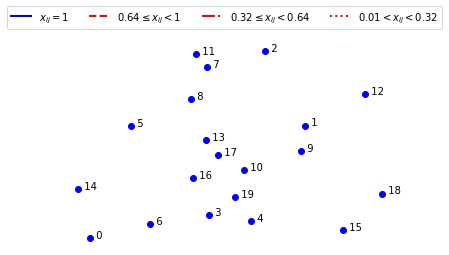

In [2]:
ran_points = Cities(n=20,seed=25)
plot_situation(ran_points)

Alternatively, we can read the `dantiz42.dat` instance which represents locations in USA.

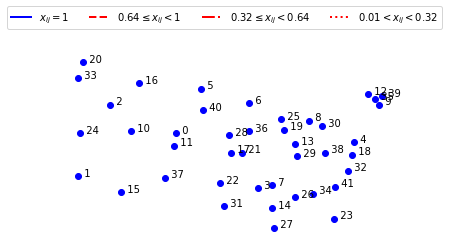

In [3]:
dantzig42 = read_instance("data/dantzig42.dat")
plot_situation(dantzig42)

## Dantzig, Fulkerson and Johnson (DFJ) Formulation

Consider the following formulation of the *symmetric traveling salesman
problem* due to Dantzig, Fulkerson and Johnson, 1954 (DFJ) that we have
been discussing during the course. Let $V=\{0..n-1\}$ be the set of nodes
and $E$ the set of edges. Let $E(S)$ be the set of edges induced by the
subset of vertices $S$ and $\delta(v)$ the set of edges in the cut
$(v,V\setminus\{v\})$. (We will assume that the instance is symmetric and that an edge between two nodes $i$ and $j$ is present in $E$ only in the form $ij$, if $j>i$, or $ji$, if $ j < i$.) 
$$
\begin{aligned}
\text{(TSPIP)}\quad \min\; & \sum c_{ij} x_{ij} \\
\text{s.t.}\;&\sum_{ij \in \delta(i)} x_{ij}+\sum_{ji \in \delta(i)}x_{ji}=2 \text{ for all } i \in V\\
&\sum_{ij \in E(S)} x_{ij} \leq |S|-1 \text{ for all } \emptyset \subset S\subset V, 2 \leq |S| \leq n-1\\
&x_{ij} \in \{0,1\} \text{ for all } {ij} \in E
\end{aligned}
$$

We can generate all subsets of the set of 20 randomly generated cities as follows: 

In [4]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

subtours = list(powerset(range(len(ran_points))))
# The first element of the list is the empty set and the last element is the full set, hence we remove them.
subtours = subtours[1:(len(subtours)-1)]

### Task 1
Implement the DFJ formulation in the model below and solve your random instance:

In [5]:
def solve_tsp(points, subtours=[], vartype=GRB.BINARY, solver="glpk", silent=True):
    points=list(points)
    V = range(len(points))
    E = [(i,j) for i in V for j in V if i<j] # complete graph

    m = gp.Model("TSP0")
    if silent:
        m.setParam(GRB.Param.OutputFlag, 0)
    ######### BEGIN: Write here your model for Task 1
    ## Vars
    
    ## Objective
    
    ## Constraints
    
    ######### END
    
    m.display
    #m.write("tsplp.lp")
    m.optimize()
    
    if m.status == GRB.status.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)
        return {e: x[e].X for e in E}
    else:
        print("Something wrong in solve_tsp")
        raise SystemExit

If we try to solve the small instance on 20 cities with this model, ie:
```python
solve_tsp(ran_points, subtours)
```
we get out of memory (you can be more lucky but if so try increasing your instance with a few more cities).


Beside the DFJ formulation with cutting plane procedure there are
other formulations for the TSP that we saw in class and that have a
polynomial number of constraints:

- the MTZ formulation (C. E. Miller, A. W. Tucker, and R. A. Zemlin,
“Integer programming formulations and traveling salesman problems,” J.
ACM, 7 (1960), pp. 326–329)

- the Flow with Gain by Svestka (JA Svestka, "A continuous variable representation of the TSP," Math Prog, v15, 1978, pp 211-213)

- the step model by Dantzig ("Linear Programming and Extensions" 1963, Dantzig G.B.)


Your tasks:


+ Argue that the formulations are correct for the traveling salesman
problem, that is, show that a solution to the traveling salesman
satisfies all constraints given and that a solution with subtours
would be ruled out by the formulation.


+ Solve the instance on the 20 random nodes with the formulations
given keeping the integrality requirement for the main variables so
that the optimal solution can be found. Which formulation is the
fastest to solve the problem? How many branch and bound nodes are
needed in each formulation to find the optimal solution?


+ Compare the DFJ and MTZ formulations on the basis of the quality of
their linear relaxations on the instance with random points and on the
instances `dantzig42`, `berlin52.dat`, `bier127.dat`. Can they all
solve these instances?  Which formulation provides the tigthest LP
relaxation?


+ Experiment ideas to solve the instance. For example, try combining
the DFJ formulation with one of those here.

